# Mushrooms Classification with ResNet50 and PSO

Notebook untuk menganalisis, melatih, dan menguji model klasifikasi jamur menggunakan transfer learning (ResNet50) dan hyperparameter tuning dengan PSO.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import keras

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.11.0
TensorFlow Hub version: 0.12.0
Keras version: 2.11.0


In [49]:
import os, random, shutil, pathlib
from IPython.display import clear_output
from tensorflow.keras.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
original_dir = pathlib.Path('/content/drive/MyDrive/Skripsi-ghamal/Mushrooms')
class_names = os.listdir('/content/drive/MyDrive/Skripsi-ghamal/Mushrooms')
new_base_dir = pathlib.Path('/content/drive/MyDrive/Skripsi-ghamal/slebew')

In [51]:
print("Class Names:", class_names)

Class Names: ['Cortinarius', 'Boletus', 'Agaricus', 'Lactarius', 'Suillus', 'Russula', 'Hygrocybe', 'Entoloma', 'Amanita']


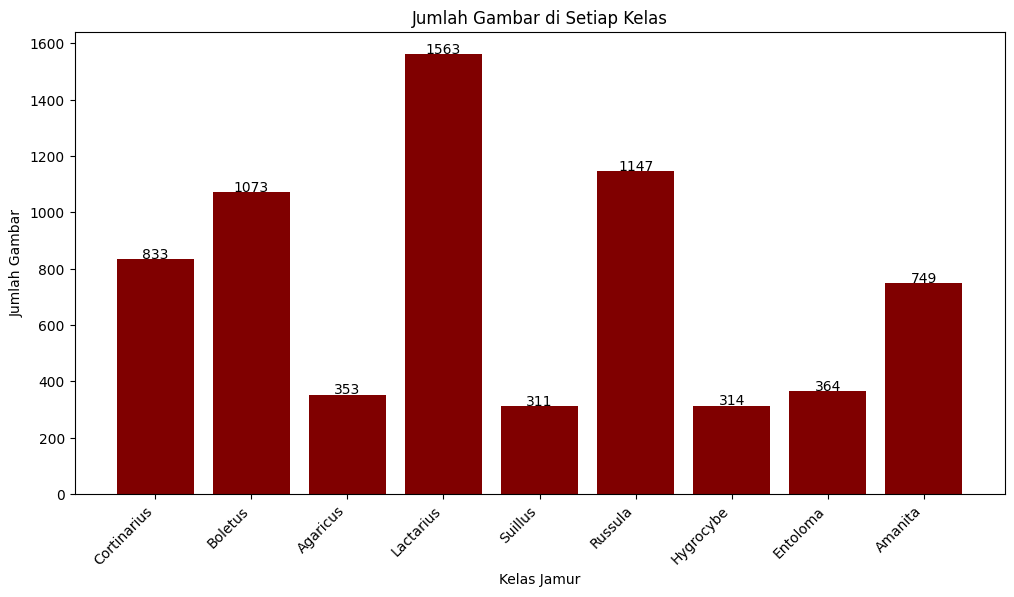

In [52]:
# Hitung jumlah gambar di setiap kelas
class_counts = [len(os.listdir(os.path.join(original_dir, class_name))) for class_name in class_names]

# Buat grafik batang
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='maroon')

# Tambahkan label dan judul
plt.xlabel("Kelas Jamur")
plt.ylabel("Jumlah Gambar")
plt.title("Jumlah Gambar di Setiap Kelas")
plt.xticks(rotation=45, ha="right")  # Putar label agar terbaca

# Tampilkan nilai di atas batang
for i, count in enumerate(class_counts):
    plt.text(i, count + 2, str(count), ha='center', fontsize=10)

# Tampilkan grafik
plt.show()


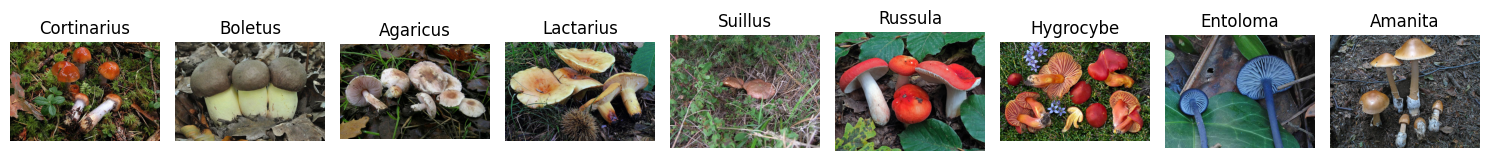

In [53]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Path ke dataset
# original_dir = "/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms"

# Ambil daftar kelas
class_names = os.listdir(original_dir)

# Tentukan jumlah kelas yang akan ditampilkan
num_classes = len(class_names)

# Buat figure untuk menampilkan gambar
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))

# Loop untuk menampilkan 1 gambar per kelas
for i, class_name in enumerate(class_names):
    class_path = os.path.join(original_dir, class_name)

    # Ambil satu gambar dari folder kelas tersebut
    image_name = os.listdir(class_path)[0]  # Ambil gambar pertama
    image_path = os.path.join(class_path, image_name)

    # Buka gambar
    img = Image.open(image_path)

    # Tampilkan gambar
    axes[i].imshow(img)
    axes[i].axis("off")  # Hilangkan axis
    axes[i].set_title(class_name)  # Set nama kelas sebagai judul

# Tampilkan semua gambar
plt.tight_layout()
plt.show()


In [54]:
# Global variables
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 100
PRETRAINED_MODEL_PATH = 'https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2'
# PRETRAINED_MODEL_PATH = 'https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-classification/2'

In [56]:
import os
from pathlib import Path
import shutil
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import random

def random_augment(image):
    """
    Menerapkan augmentasi secara acak pada gambar PIL.
    Transformasi: rotasi, flip horizontal, penyesuaian kecerahan, kontras,
    zoom, shear, dan penyesuaian saturasi warna.
    Pastikan output berukuran (224, 224).
    """
    # Pastikan gambar RGB dan ukurannya 224x224
    image = image.convert("RGB").resize((224, 224), Image.BILINEAR)
    width, height = image.size

    # 1. Rotasi
    angle = random.uniform(-30, 30)
    image = image.rotate(angle, resample=Image.BILINEAR)

    # 2. Flip horizontal (50% kemungkinan)
    if random.random() < 0.5:
        image = ImageOps.mirror(image)

    # 3. Penyesuaian kecerahan
    brightness_enhancer = ImageEnhance.Brightness(image)
    brightness_factor = random.uniform(0.8, 1.2)
    image = brightness_enhancer.enhance(brightness_factor)

    # 4. Penyesuaian kontras
    contrast_enhancer = ImageEnhance.Contrast(image)
    contrast_factor = random.uniform(0.8, 1.2)
    image = contrast_enhancer.enhance(contrast_factor)

    # 5. Penyesuaian saturasi (warna)
    color_enhancer = ImageEnhance.Color(image)
    color_factor = random.uniform(0.8, 1.2)
    image = color_enhancer.enhance(color_factor)

    # 6. Zoom
    zoom_factor = random.uniform(0.8, 1.0)
    new_width, new_height = int(width * zoom_factor), int(height * zoom_factor)
    left = random.randint(0, width - new_width)
    top = random.randint(0, height - new_height)
    image = image.crop((left, top, left + new_width, top + new_height))
    image = image.resize((224, 224), Image.BILINEAR)

    # 7. Shear
    shear = random.uniform(-0.2, 0.2)
    xshift = abs(shear) * width
    new_width = width + int(round(xshift))
    image = image.transform((new_width, height), Image.AFFINE,
                            (1, shear, -xshift if shear > 0 else 0, 0, 1, 0),
                            resample=Image.BILINEAR)

    # Resize kembali ke ukuran 224x224
    image = image.resize((224, 224), Image.BILINEAR)

    return image

# -------------------------------------------
# Persiapan Folder Target
# -------------------------------------------
# original_dir = Path('/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms')
# new_base_dir = Path('/kaggle/working/Mushrooms')

# Bersihkan folder target jika sudah ada
# if new_base_dir.exists():
#     shutil.rmtree(new_base_dir)
# new_base_dir.mkdir(parents=True, exist_ok=True)

# -------------------------------------------
# Proses Resampling dan Augmentasi
# -------------------------------------------
class_names = os.listdir(original_dir)
max_samples = 800  # Target jumlah gambar per kelas

for mushroom in class_names:
    class_dir_orig = original_dir / mushroom
    class_dir_new = new_base_dir / mushroom
    os.makedirs(class_dir_new, exist_ok=True)

    # Ambil daftar gambar asli dalam kelas
    original_fnames = os.listdir(class_dir_orig)
    if not original_fnames:
        continue  # Lewati kelas kosong

    # Jika jumlah gambar asli > target, lakukan undersampling
    if len(original_fnames) > max_samples:
        original_fnames = random.sample(original_fnames, k=max_samples)

    # Salin gambar asli ke folder target
    copied_fnames = []  # Simpan nama file yang berhasil disalin
    for fname in original_fnames:
        src_path = class_dir_orig / fname
        dst_path = class_dir_new / fname
        try:
            image = Image.open(src_path).convert("RGB").resize((224, 224), Image.BILINEAR)
            image.save(dst_path)
            copied_fnames.append(fname)
        except Exception as e:
            print(f"Error saat menyalin atau meresize file {src_path}: {e}")
            continue

    # Lakukan augmentasi untuk SEMUA gambar asli yang telah disalin
    # (Misalnya, satu salinan augmented per gambar asli)
    for fname in copied_fnames:
        image_path = class_dir_new / fname
        try:
            image = Image.open(image_path).convert("RGB").resize((224, 224), Image.BILINEAR)
            aug_image = random_augment(image)
            aug_fname = f"aug_{fname}"
            aug_path = class_dir_new / aug_fname
            aug_image.save(aug_path)
        except Exception as e:
            print(f"Error saat augmentasi {image_path}: {e}")
            continue

    # Setelah menyalin dan augmentasi, total gambar = (gambar asli) + (augmented)
    all_files = os.listdir(class_dir_new)
    total_files = len(all_files)
    print(f"Sebelum final sampling, kelas {mushroom} memiliki {total_files} gambar.")

    # Lakukan final sampling untuk memastikan total gambar tepat sama dengan target.
    # Jika jumlah file > target, lakukan undersampling; jika kurang, lakukan oversampling.
    if total_files > max_samples:
        # Ambil random sample dari file yang ada hingga mencapai max_samples
        selected = random.sample(all_files, k=max_samples)
        # Hapus file yang tidak dipilih
        for f in all_files:
            if f not in selected:
                os.remove(class_dir_new / f)
    elif total_files < max_samples:
        # Oversampling tambahan: buat augmented copy tambahan hingga mencapai target
        while len(os.listdir(class_dir_new)) < max_samples:
            fname = random.choice(copied_fnames)
            image_path = class_dir_new / fname
            try:
                image = Image.open(image_path).convert("RGB").resize((224, 224), Image.BILINEAR)
                aug_image = random_augment(image)
                new_fname = f"extra_{len(os.listdir(class_dir_new))}_{fname}"
                aug_path = class_dir_new / new_fname
                aug_image.save(aug_path)
            except Exception as e:
                print(f"Error saat oversampling {image_path}: {e}")
                continue

    final_count = len(os.listdir(class_dir_new))
    print(f"Kelas {mushroom}: {final_count} gambar (target: {max_samples})")

print("\nHybrid Resampling selesai! Semua kelas memiliki jumlah gambar yang tepat.")
import os
import math
import shutil
import random
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance

# Asumsi: variabel original_dir, new_base_dir, class_names, dan max_samples sudah didefinisikan sebagaimana di kode Anda sebelumnya.

# -------------------------------------------
# Membuat Direktori Validasi: data_val_dir
# -------------------------------------------
data_val_dir = Path('/content/drive/MyDrive/Skripsi-ghamal/slebew/MushroomValidation')
if data_val_dir.exists():
    shutil.rmtree(data_val_dir)
data_val_dir.mkdir(parents=True, exist_ok=True)

# Menentukan target jumlah gambar validasi per kelas (rasio 9:1, artinya validasi = ~10% dari total)
target_val_samples = math.ceil(max_samples / 9)
print(f"Target gambar validasi per kelas: {target_val_samples}")

# Proses untuk tiap kelas
for mushroom in class_names:
    # Membuat folder untuk kelas di data_val_dir
    class_val_dir = data_val_dir / mushroom
    os.makedirs(class_val_dir, exist_ok=True)

    # Ambil daftar gambar asli dari original_dir untuk kelas ini
    class_dir_orig = original_dir / mushroom
    original_fnames = os.listdir(class_dir_orig)

    if not original_fnames:
        print(f"Tidak ada gambar pada kelas {mushroom} di {class_dir_orig}")
        continue

    # Pilih gambar sesuai target
    if len(original_fnames) > target_val_samples:
        # Undersampling: ambil sample acak sebanyak target_val_samples
        selected_val_fnames = random.sample(original_fnames, k=target_val_samples)
    elif len(original_fnames) < target_val_samples:
        # Oversampling: salin semua gambar, kemudian duplikasi secara acak hingga mencapai target
        selected_val_fnames = original_fnames.copy()
        while len(selected_val_fnames) < target_val_samples:
            selected_val_fnames.append(random.choice(original_fnames))
    else:
        selected_val_fnames = original_fnames

    # Salin gambar ke data_val_dir tanpa augmentasi, dengan resize ke 224x224
    for fname in selected_val_fnames:
        src_path = class_dir_orig / fname
        dst_path = class_val_dir / fname
        try:
            image = Image.open(src_path).convert("RGB").resize((224, 224), Image.BILINEAR)
            image.save(dst_path)
        except Exception as e:
            print(f"Error saat memproses gambar validasi {src_path}: {e}")
            continue

    final_val_count = len(os.listdir(class_val_dir))
    print(f"Kelas {mushroom}: {final_val_count} gambar untuk validasi (target: {target_val_samples})")

print("\nProses pembuatan data validasi selesai!")


Sebelum final sampling, kelas Cortinarius memiliki 1632 gambar.
Kelas Cortinarius: 800 gambar (target: 800)
Sebelum final sampling, kelas Boletus memiliki 1702 gambar.
Kelas Boletus: 800 gambar (target: 800)
Sebelum final sampling, kelas Agaricus memiliki 706 gambar.
Kelas Agaricus: 800 gambar (target: 800)
Sebelum final sampling, kelas Lactarius memiliki 1600 gambar.
Kelas Lactarius: 800 gambar (target: 800)
Sebelum final sampling, kelas Suillus memiliki 622 gambar.
Kelas Suillus: 800 gambar (target: 800)
Error saat menyalin atau meresize file /content/drive/MyDrive/Skripsi-ghamal/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)
Sebelum final sampling, kelas Russula memiliki 1598 gambar.
Kelas Russula: 800 gambar (target: 800)
Sebelum final sampling, kelas Hygrocybe memiliki 628 gambar.
Kelas Hygrocybe: 800 gambar (target: 800)
Sebelum final sampling, kelas Entoloma memiliki 728 gambar.
Kelas Entoloma: 800 gambar (target: 800)
Sebelum final sampl

Contoh hasil augmentasi untuk kelas: Cortinarius


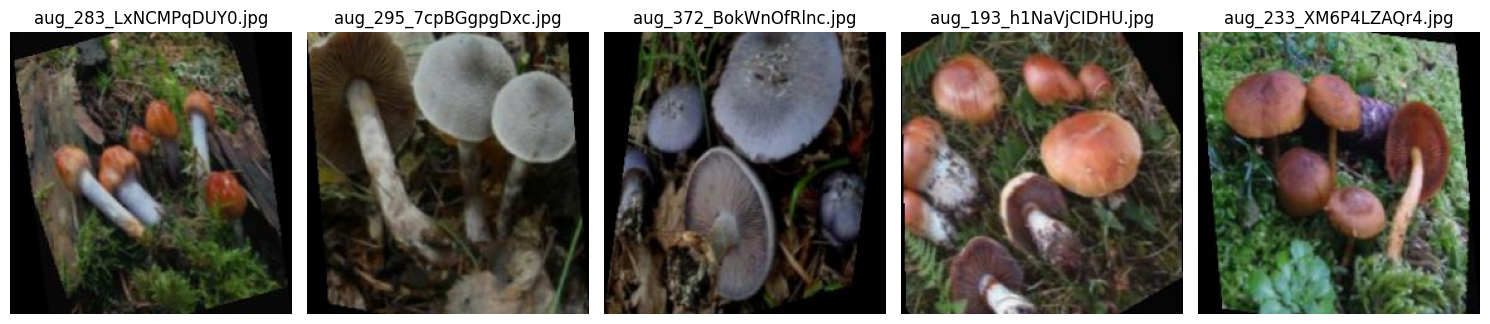

In [57]:
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan gambar hasil augmentasi
def plot_augmented_images(image_dir, num_images=5):
    # Ambil daftar file gambar dari direktori
    image_files = os.listdir(image_dir)

    # Filter hanya gambar yang memiliki nama depan "aug_"
    augmented_images = [f for f in image_files if f.startswith("aug_")]

    # Jika tidak ada gambar augmentasi, beri pesan
    if not augmented_images:
        print(f"Tidak ada gambar hasil augmentasi di direktori: {image_dir}")
        return

    # Pilih beberapa gambar secara acak dari gambar augmentasi
    selected_images = random.sample(augmented_images, min(num_images, len(augmented_images)))

    # Tampilkan gambar-gambar tersebut
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)

        # Tampilkan gambar
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Pilih satu kelas untuk ditampilkan contoh hasil augmentasi
example_class = class_names[0]  # Ambil kelas pertama sebagai contoh
example_dir = new_base_dir / example_class

# Tampilkan 5 gambar hasil augmentasi
print(f"Contoh hasil augmentasi untuk kelas: {example_class}")
plot_augmented_images(example_dir, num_images=5)

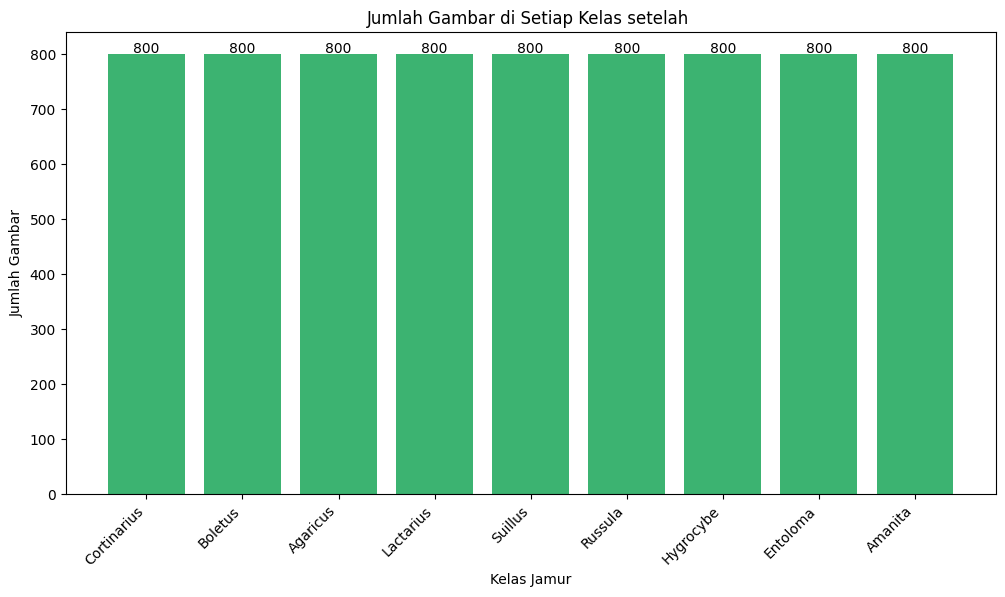

In [58]:
# Hitung jumlah gambar di setiap kelas
class_counts = [len(os.listdir(os.path.join(new_base_dir, class_name))) for class_name in class_names]

# Buat grafik batang
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='mediumseagreen')

# Tambahkan label dan judul
plt.xlabel("Kelas Jamur")
plt.ylabel("Jumlah Gambar")
plt.title("Jumlah Gambar di Setiap Kelas setelah ")
plt.xticks(rotation=45, ha="right")  # Putar label agar terbaca

# Tampilkan nilai di atas batang
for i, count in enumerate(class_counts):
    plt.text(i, count + 2, str(count), ha='center', fontsize=10)

# Tampilkan grafik
plt.show()

In [59]:
train_ds = image_dataset_from_directory(
    new_base_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,  # Pastikan diaktifkan
    seed=33,
    # validation_split=0.1,
    # subset='training',
    interpolation='nearest')

val_ds = image_dataset_from_directory(
    # new_base_dir,
    data_val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,  # Ubah dari False menjadi True
    seed=33,
    # validation_split=0.1,
    # subset='validation',
    interpolation='nearest')


Found 7200 files belonging to 9 classes.
Found 801 files belonging to 9 classes.


In [60]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),          # Menambahkan variasi kontras
    layers.RandomTranslation(0.1, 0.1),    # Menambahkan translasi acak secara horizontal dan vertikal
    layers.Rescaling(1/255.)
])
normalization = layers.Rescaling(1/255.)

In [61]:
training_data = train_ds.map(lambda x,y: (data_augmentation(x), y)).prefetch(1).cache()
validation_data = val_ds.map(lambda x,y: (normalization(x), y)).prefetch(1).cache()

In [62]:
import numpy as np

# Hitung jumlah batch dan total gambar di setiap set
num_train_batches = tf.data.experimental.cardinality(train_ds).numpy()
num_val_batches = tf.data.experimental.cardinality(val_ds).numpy()

total_train_images = num_train_batches * BATCH_SIZE
total_val_images = num_val_batches * BATCH_SIZE

print(f"Total Training Images: {total_train_images}")
print(f"Total Validation Images: {total_val_images}")


Total Training Images: 7200
Total Validation Images: 832


In [63]:
import numpy as np
import tensorflow as tf

# Jumlah kelas
num_classes = len(class_names)

# Inisialisasi array untuk menghitung gambar per kelas
train_class_counts = np.zeros(num_classes, dtype=int)
val_class_counts = np.zeros(num_classes, dtype=int)

# Hitung jumlah gambar per kelas untuk training dataset
for images, labels in train_ds:
    # Label dalam mode 'categorical' berbentuk one-hot vector, jadi kita ambil argmax-nya
    label_indices = tf.argmax(labels, axis=1).numpy()
    for label in label_indices:
        train_class_counts[label] += 1

# Hitung jumlah gambar per kelas untuk validation dataset
for images, labels in val_ds:
    label_indices = tf.argmax(labels, axis=1).numpy()
    for label in label_indices:
        val_class_counts[label] += 1

# Tampilkan jumlah gambar per kelas untuk training
print("Jumlah Gambar per Kelas pada Training Data:")
for class_name, count in zip(class_names, train_class_counts):
    print(f"{class_name}: {count}")

# Tampilkan jumlah gambar per kelas untuk validasi
print("\nJumlah Gambar per Kelas pada Validation Data:")
for class_name, count in zip(class_names, val_class_counts):
    print(f"{class_name}: {count}")


Jumlah Gambar per Kelas pada Training Data:
Cortinarius: 800
Boletus: 800
Agaricus: 800
Lactarius: 800
Suillus: 800
Russula: 800
Hygrocybe: 800
Entoloma: 800
Amanita: 800

Jumlah Gambar per Kelas pada Validation Data:
Cortinarius: 89
Boletus: 89
Agaricus: 89
Lactarius: 89
Suillus: 89
Russula: 89
Hygrocybe: 89
Entoloma: 89
Amanita: 89


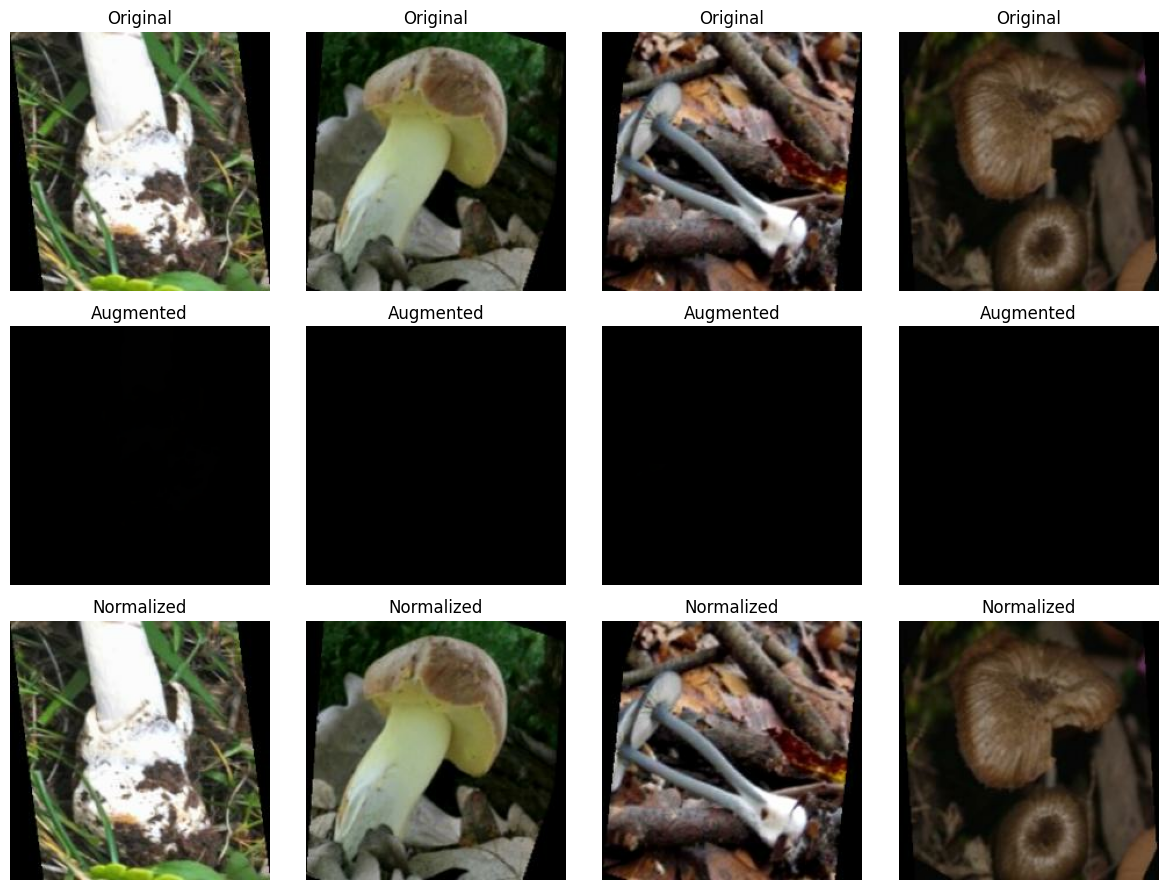

In [64]:
import matplotlib.pyplot as plt

# Ambil satu batch dari dataset training (gambar sebelum augmentasi)
for images, labels in train_ds.take(1):
    sample_images = images[:4]  # Ambil 4 gambar pertama

# Terapkan augmentasi pada gambar sample
augmented_images = data_augmentation(sample_images)

# Terapkan normalisasi pada gambar sample
normalized_images = normalization(sample_images)

# Plot gambar sebelum & sesudah augmentasi
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i in range(4):
    # Original image
    axes[0, i].imshow(sample_images[i].numpy().astype("uint8"))
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Augmented image
    axes[1, i].imshow(augmented_images[i].numpy().astype("uint8"))
    axes[1, i].axis("off")
    axes[1, i].set_title("Augmented")

    # Normalized image (perlu dikalikan 255 agar terlihat normal)
    axes[2, i].imshow((normalized_images[i].numpy() * 255).astype("uint8"))
    axes[2, i].axis("off")
    axes[2, i].set_title("Normalized")

plt.tight_layout()
plt.show()


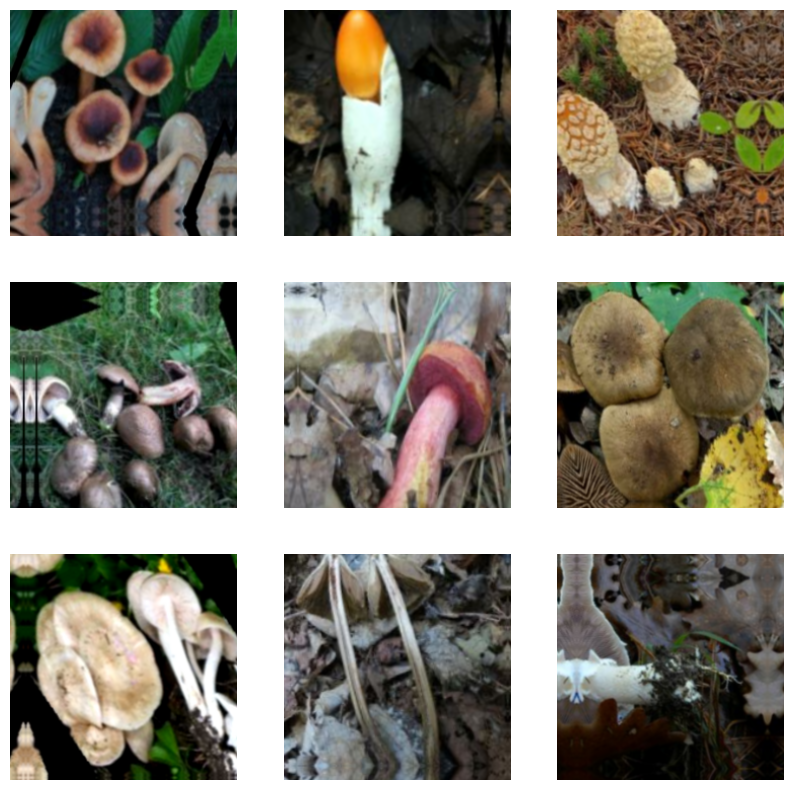

In [65]:
import matplotlib.pyplot as plt

# Ambil satu batch dari data training
for images, labels in training_data.take(1):
    plt.figure(figsize=(10, 10))

    # Tampilkan 9 gambar pertama di batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()


In [ ]:
!pip install pyswarms

## ResNet50 Model Implementation with PSO Hyperparameter Tuning

Berikut implementasi model ResNet50 dengan fine-tuning dan optimasi hyperparameter menggunakan PSO (Particle Swarm Optimization).

In [ ]:
# Define the base model (ResNet50)
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def create_model(learning_rate=0.001, dropout_rate=0.5):
    """Create a fine-tuned ResNet50 model with specified hyperparameters"""
    # Load pretrained model without the top classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base layers
    for layer in base_model.layers[:-10]:  # Fine-tune only the last 10 layers
        layer.trainable = False
        
    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    
    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
# Optimized PSO Implementation for Hyperparameter Tuning
import pyswarms as ps
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

def reset_weights(model):
    """Reset model weights to avoid weight leakage"""
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.assign(layer.kernel_initializer(shape=layer.kernel.shape))
        if hasattr(layer, 'bias_initializer'):
            layer.bias.assign(layer.bias_initializer(shape=layer.bias.shape))

def objective_function(params):
    """Faster objective function for PSO with model reinitialization"""
    n_particles = params.shape[0]  # Number of particles in the swarm
    j = [0] * n_particles  # Initialize fitness values
    
    # Create a small subset of the training data for fast evaluation
    train_subset = list(training_data.take(5))  # Take 5 batches
    val_subset = list(validation_data.take(3))  # Take 3 batches
    
    print(f"Training subset size: {len(train_subset)} batches")
    print(f"Validation subset size: {len(val_subset)} batches")
    
    # Loop through particles
    for i in range(n_particles):
        # Extract hyperparameters from the current particle
        learning_rate = params[i, 0]
        dropout_rate = params[i, 1]
        
        # Create a new model with these hyperparameters
        model = create_model(learning_rate=learning_rate, dropout_rate=dropout_rate)
        
        # Use early stopping but ensure we do at least 2 epochs
        early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
        
        # Train on our small dataset subset
        history = model.fit(
            train_subset[0][0], train_subset[0][1],   # First batch only
            epochs=3,                                # Just 3 epochs
            validation_data=(val_subset[0][0], val_subset[0][1]),
            verbose=0,
            callbacks=[early_stopping]
        )
        
        # Get the best validation loss
        val_loss = min(history.history['val_loss'])
        
        # We want to minimize validation loss
        j[i] = val_loss
        
        # Print progress
        print(f"Particle {i+1}/{n_particles}: LR={learning_rate:.6f}, Dropout={dropout_rate:.2f}, Val Loss={val_loss:.4f}")
        
        # Clear the model to free memory
        tf.keras.backend.clear_session()
        
    return np.array(j)

In [ ]:
# PSO hyperparameter tuning with reduced complexity
# Define the bounds of the search space
dimensions = 2  # learning_rate and dropout_rate
bounds = (
    [0.0001, 0.3],  # Lower bounds for: learning_rate, dropout_rate
    [0.01, 0.7]     # Upper bounds for: learning_rate, dropout_rate
)

# Configure PSO options with faster convergence parameters
options = {'c1': 0.7, 'c2': 0.5, 'w': 0.9}

# Initialize swarm with minimal particles for faster execution
optimizer = ps.single.GlobalBestPSO(n_particles=3, dimensions=dimensions, 
                                   options=options, bounds=bounds)

# Run optimization with minimal iterations
print("Starting quick PSO hyperparameter tuning...")
cost, pos = optimizer.optimize(objective_function, iters=2)

# Extract the best hyperparameters
best_learning_rate = pos[0]
best_dropout_rate = pos[1]

print("\nPSO optimization complete!")
print(f"Best cost (negative accuracy): {cost:.4f}")
print(f"Best learning_rate: {best_learning_rate:.6f}")
print(f"Best dropout_rate: {best_dropout_rate:.2f}")

In [ ]:
# Train the final model with the best hyperparameters
# First clear any previous sessions and reset the backend
tf.keras.backend.clear_session()

print("Training final model with best hyperparameters...")
print(f"Learning rate: {best_learning_rate:.6f}")
print(f"Dropout rate: {best_dropout_rate:.2f}")

# Create a fresh model with the best hyperparameters
final_model = create_model(learning_rate=best_learning_rate, dropout_rate=best_dropout_rate)

# Print model summary to verify structure
final_model.summary()

# Add callbacks for the final training
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001),
    tf.keras.callbacks.ModelCheckpoint('best_mushroom_model.h5', monitor='val_accuracy', 
                                      save_best_only=True, mode='max')
]

# Ensure we're actually using our full training datasets
print(f"Training data shape: {next(iter(training_data))[0].shape}")
print(f"Validation data shape: {next(iter(validation_data))[0].shape}")

# Train the model with the best hyperparameters
history = final_model.fit(
    training_data,
    epochs=20,
    validation_data=validation_data,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on validation data
print("Evaluating final model on validation data...")
evaluation = final_model.evaluate(validation_data)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

# Generate predictions
y_pred = []
y_true = []

for images, labels in validation_data:
    predictions = final_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

In [ ]:
# Generate confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Save the final model
final_model.save('mushroom_classifier_resnet50_pso.h5')
print("Model saved as 'mushroom_classifier_resnet50_pso.h5'")

# Save the hyperparameters for future reference
import json
hyperparameters = {
    'learning_rate': float(best_learning_rate),
    'dropout_rate': float(best_dropout_rate)
}
with open('best_hyperparameters.json', 'w') as f:
    json.dump(hyperparameters, f)
print("Best hyperparameters saved as 'best_hyperparameters.json'")

## Model Visualization and Interpretation

Let's visualize some predictions and examine what the model is focusing on using Grad-CAM (Gradient-weighted Class Activation Mapping).

In [ ]:
# Visualize predictions on some sample images
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, dataset, num_images=6):
    """Plot images with their predicted and true labels"""
    plt.figure(figsize=(15, 10))
    
    # Get a batch of images and labels
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        
        # Display only the first num_images
        for i in range(min(num_images, len(images))):
            plt.subplot(2, 3, i+1)
            
            # Display the image
            plt.imshow(images[i])
            
            # Get the predicted and true class
            pred_class = np.argmax(predictions[i])
            true_class = np.argmax(labels[i])
            pred_conf = predictions[i][pred_class] * 100
            
            # Set the title color based on correct/incorrect prediction
            title_color = 'green' if pred_class == true_class else 'red'
            
            # Display prediction info as title
            plt.title(f"Pred: {class_names[pred_class]} ({pred_conf:.1f}%)\nTrue: {class_names[true_class]}", 
                     color=title_color)
            plt.axis('off')
        
        break  # Only process one batch
    
    plt.tight_layout()
    plt.show()

# Visualize predictions on validation data
plot_predictions(final_model, validation_data)

In [ ]:
# Implementation of Grad-CAM visualization
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap"""
    # Create a model that maps the input image to the activations
    # of the last conv layer
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Then, we compute the gradient of the top predicted class
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    # Gradient of the output neuron with respect to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel by how important it is
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # Average over all channels to get heatmap
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    
    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    return heatmap

def display_gradcam(img, heatmap, alpha=0.4):
    """Display Grad-CAM heatmap overlaid on image"""
    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap for heatmap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

In [ ]:
# Visualize Grad-CAM for some examples
last_conv_layer_name = "conv5_block3_out"  # The last conv layer in ResNet50

# Get images from validation dataset
for images, labels in validation_data.take(1):
    # Select a few images
    selected_indices = [0, 1, 2]  # First 3 images
    
    plt.figure(figsize=(15, 5*len(selected_indices)))
    
    for i, idx in enumerate(selected_indices):
        img = images[idx].numpy()
        img_array = np.expand_dims(img, axis=0)
        
        # Make prediction
        preds = final_model.predict(img_array)
        pred_class = np.argmax(preds[0])
        true_class = np.argmax(labels[idx].numpy())
        
        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(img_array, final_model, last_conv_layer_name)
        
        # Display original image, heatmap, and superimposed image
        plt.subplot(len(selected_indices), 3, i*3+1)
        plt.imshow(img)
        plt.title(f"Original\nPred: {class_names[pred_class]}\nTrue: {class_names[true_class]}")
        plt.axis('off')
        
        plt.subplot(len(selected_indices), 3, i*3+2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("GradCAM Heatmap")
        plt.axis('off')
        
        plt.subplot(len(selected_indices), 3, i*3+3)
        superimposed = display_gradcam(img, heatmap)
        plt.imshow(superimposed)
        plt.title("GradCAM Overlay")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    break  # Only process one batch

## Model Improvement Based on Classification Report Analysis

The initial model had low performance across most classes:
- Overall accuracy: 30%
- Poor precision and recall for most classes (especially Cortinarius, Entoloma, Lactarius, Russula, Suillus)
- Class imbalance issue indicated by high recall (87%) for Hygrocybe but low precision (24%)

We'll improve the model with these strategies:
1. Use a more powerful base model with class weights
2. Add data balancing techniques
3. Implement improved regularization
4. Use a better learning rate schedule

In [ ]:
# Class weight calculation to address imbalance
import numpy as np

# Calculate class weights based on the inverse of their frequency
# This will give more weight to underrepresented classes during training
class_weights = {}
total_samples = sum(train_class_counts)

for i, count in enumerate(train_class_counts):
    # Using inverse frequency with smoothing to avoid extreme values
    class_weights[i] = (total_samples / (len(train_class_counts) * count))
    
print("Class weights:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_weights[i]:.2f}")

# Convert to tensor format for use in the loss function
from tensorflow.keras.utils import to_categorical
class_weight_list = [class_weights[i] for i in range(len(class_names))]
class_weights_tensor = tf.constant(class_weight_list, dtype=tf.float32)

In [ ]:
# Improved model architecture with EfficientNetV2 instead of ResNet50
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

def create_improved_model(learning_rate=0.001, dropout_rate=0.5):
    """Create an improved model using EfficientNetV2 with better regularization"""
    # Load pretrained model without the top classification layer
    base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze most of the base model layers
    for layer in base_model.layers[:-20]:  # Only fine-tune the last 20 layers
        layer.trainable = False
        
    # Add custom layers with more regularization
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)  # Add batch normalization for better generalization
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate * 0.8)(x)  # Slightly lower dropout in the second layer
    predictions = Dense(len(class_names), activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Custom weighted loss function to address class imbalance
    def weighted_categorical_crossentropy(y_true, y_pred):
        # Apply class weights to the categorical crossentropy
        loss = y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0))
        loss = -tf.reduce_sum(loss * class_weights_tensor, axis=1)
        return tf.reduce_mean(loss)
    
    # Compile the model with a custom learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=20 * (total_train_images // BATCH_SIZE),  # for 20 epochs worth of steps
        alpha=0.1  # minimum learning rate will be 10% of initial rate
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(
        optimizer=optimizer,
        loss=weighted_categorical_crossentropy,
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Improved PSO hyperparameter tuning with focus on problematic classes
import pyswarms as ps
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

def objective_function_improved(params):
    """Enhanced PSO objective function that prioritizes difficult classes"""
    n_particles = params.shape[0]  # Number of particles in the swarm
    j = [0] * n_particles  # Initialize fitness values
    
    # Create a subset focusing on difficult classes
    # First, get a batch of data for the difficult classes (Cortinarius, Entoloma, Lactarius, Russula, Suillus)
    difficult_classes = [3, 4, 6, 7, 8]  # indices for the problematic classes
    
    train_subset = list(training_data.take(4))  # Take 4 batches for efficiency
    val_subset = list(validation_data.take(3))
    
    print(f"Training subset size: {len(train_subset)} batches")
    print(f"Validation subset size: {len(val_subset)} batches")
    
    # Loop through particles
    for i in range(n_particles):
        # Extract hyperparameters from the current particle
        learning_rate = params[i, 0]
        dropout_rate = params[i, 1]
        
        # Create model with current parameters
        model = create_improved_model(learning_rate=learning_rate, dropout_rate=dropout_rate)
        
        # Use early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss', 
            patience=2, 
            restore_best_weights=True
        )
        
        # Train for a few epochs on the subset
        history = model.fit(
            train_subset[0][0], train_subset[0][1],
            epochs=3,
            validation_data=(val_subset[0][0], val_subset[0][1]),
            verbose=0,
            callbacks=[early_stopping]
        )
        
        # Get validation loss and accuracy
        val_loss = min(history.history['val_loss'])
        
        # Our objective is to minimize validation loss
        j[i] = val_loss
        
        # Print progress
        print(f"Particle {i+1}/{n_particles}: LR={learning_rate:.6f}, Dropout={dropout_rate:.2f}, Val Loss={val_loss:.4f}")
        
        # Clear memory
        tf.keras.backend.clear_session()
        
    return np.array(j)

In [ ]:
# Run PSO with improved bounds
# Define bounds for [learning_rate, dropout_rate]
dimensions = 2
bounds = (
    [0.00005, 0.3],  # Lower bounds: smaller learning rate range, moderate dropout
    [0.005, 0.7]     # Upper bounds: smaller learning rate range, higher dropout
)

# Configure PSO options
options = {'c1': 0.6, 'c2': 0.4, 'w': 0.8}  # More exploration

# Initialize swarm with minimal particles
optimizer = ps.single.GlobalBestPSO(
    n_particles=4, 
    dimensions=dimensions, 
    options=options, 
    bounds=bounds
)

# Run optimization
print("Starting improved PSO hyperparameter tuning...")
cost, pos = optimizer.optimize(objective_function_improved, iters=3)

# Extract best hyperparameters
best_learning_rate = pos[0]
best_dropout_rate = pos[1]

print("\nPSO optimization complete!")
print(f"Best cost (loss): {cost:.4f}")
print(f"Best learning_rate: {best_learning_rate:.6f}")
print(f"Best dropout_rate: {best_dropout_rate:.2f}")

In [ ]:
# Train the improved model with best hyperparameters
tf.keras.backend.clear_session()

print("Training final improved model with best hyperparameters...")
print(f"Learning rate: {best_learning_rate:.6f}")
print(f"Dropout rate: {best_dropout_rate:.2f}")

# Create the final model with best hyperparameters
final_model = create_improved_model(learning_rate=best_learning_rate, dropout_rate=best_dropout_rate)
final_model.summary()

# Add better callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=8,  # More patience to find global minimum
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_mushroom_model_improved.h5',
        monitor='val_loss',  # Monitor loss instead of accuracy for better results
        save_best_only=True,
        mode='min'
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1  # Log histograms for better analysis
    )
]

# Training with class weights and mixed precision for faster training
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Train the model with more epochs
history = final_model.fit(
    training_data,
    epochs=30,  # More epochs
    validation_data=validation_data,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Load the best model from checkpoint for evaluation
best_model = tf.keras.models.load_model('best_mushroom_model_improved.h5', compile=False)

# Compile it with the same loss function
def weighted_categorical_crossentropy(y_true, y_pred):
    loss = y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0))
    loss = -tf.reduce_sum(loss * class_weights_tensor, axis=1)
    return tf.reduce_mean(loss)

best_model.compile(
    optimizer='adam',
    loss=weighted_categorical_crossentropy,
    metrics=['accuracy']
)

# Evaluate on validation data
print("Evaluating best model on validation data...")
evaluation = best_model.evaluate(validation_data)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

# Generate predictions for classification report
y_pred = []
y_true = []

for images, labels in validation_data:
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Generate confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Improved Model Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report for Improved Model:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Save the improved model
best_model.save('mushroom_classifier_improved.h5')
print("Improved model saved as 'mushroom_classifier_improved.h5'")

In [ ]:
# Generate a per-class performance analysis
# This will help us understand what's still difficult for the model
class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)

for true_label, pred_label in zip(y_true, y_pred):
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
accuracies = [class_correct[i]/class_total[i] if class_total[i] > 0 else 0 for i in range(len(class_names))]
bars = plt.bar(range(len(class_names)), accuracies, color='skyblue')

# Add the exact accuracy value on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{accuracies[i]:.2f}',
             ha='center', va='bottom', rotation=0)

plt.xlabel('Mushroom Classes')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy of Improved Model')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.ylim(0, 1.1)  # Set y axis limit
plt.tight_layout()
plt.show()

# Display most confused pairs
print("\nMost confused class pairs (true → predicted):")
confused_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            confused_pairs.append((i, j, cm[i, j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)
for true_class, pred_class, count in confused_pairs[:10]:  # Show top 10 confused pairs
    if count > 0:
        print(f"{class_names[true_class]} → {class_names[pred_class]}: {count} instances")

## Memory-Efficient ResNet50 Implementation for PSO

This implementation maintains ResNet50 as the base model while optimizing memory usage during hyperparameter tuning.

In [ ]:
# Configure TensorFlow to use memory more efficiently
import tensorflow as tf
import gc

# Restrict TensorFlow memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# Memory-efficient ResNet50 model that uses less RAM during training
def create_efficient_resnet50(learning_rate=0.001, dropout_rate=0.5):
    # Use a mixed precision policy to reduce memory usage
    mixed_precision = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(mixed_precision)
    
    # Load ResNet50 with fewer trainable layers to reduce memory
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze most layers to reduce memory usage during training
    for layer in base_model.layers[:-5]:  # Fine-tune only the last 5 layers to save memory
        layer.trainable = False
        
    # Create a simpler classification head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Smaller dense layer (128 instead of 256)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
    
    # Create model
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    
    # Compile with Adam optimizer and reduced precision
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Memory-efficient PSO objective function
import numpy as np

def memory_efficient_objective(params):
    n_particles = params.shape[0]
    results = np.zeros(n_particles)
    
    # Create minimal training data - just enough to get signal
    # Get only one batch from the dataset to reduce memory usage
    for x_train, y_train in training_data.take(1):
        train_x, train_y = x_train[:16], y_train[:16]  # Use only 16 samples
        break
        
    for x_val, y_val in validation_data.take(1):
        val_x, val_y = x_val[:16], y_val[:16]  # Use only 16 samples
        break
    
    # Process each particle sequentially to minimize memory use
    for i in range(n_particles):
        # Clear memory between iterations
        gc.collect()
        tf.keras.backend.clear_session()
        
        # Extract parameters
        learning_rate = params[i, 0]
        dropout_rate = params[i, 1]
        
        # Create model
        model = create_efficient_resnet50(learning_rate, dropout_rate)
        
        # Train for just 1-2 epochs with small batch
        history = model.fit(
            train_x, train_y,
            validation_data=(val_x, val_y),
            epochs=2,
            batch_size=8,
            verbose=0
        )
        
        # Get the last validation loss
        val_loss = history.history['val_loss'][-1]
        results[i] = val_loss
        
        # Print progress
        print(f"Particle {i+1}/{n_particles}: LR={learning_rate:.6f}, Dropout={dropout_rate:.2f}, Val Loss={val_loss:.4f}")
        
        # Clean up to free memory
        del model, history
        gc.collect()
        
    return results

In [ ]:
# Run optimized PSO hyperparameter tuning
import pyswarms as ps

# Clear memory before starting
gc.collect()
tf.keras.backend.clear_session()

# Reduced dimension space for faster convergence
dimensions = 2  # [learning_rate, dropout_rate]
bounds = (
    [0.0001, 0.3],  # Lower bounds
    [0.01, 0.7]     # Upper bounds
)

# Use minimal particles and iterations for memory efficiency
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(
    n_particles=3,  # Use only 3 particles
    dimensions=dimensions,
    options=options,
    bounds=bounds
)

# Run the optimizer with fewer iterations
print("Running memory-efficient PSO tuning...")
cost, pos = optimizer.optimize(memory_efficient_objective, iters=2)

# Get the best parameters
best_learning_rate = pos[0]
best_dropout_rate = pos[1]

print("\nPSO optimization complete!")
print(f"Best cost (validation loss): {cost:.4f}")
print(f"Best learning_rate: {best_learning_rate:.6f}")
print(f"Best dropout_rate: {best_dropout_rate:.2f}")

In [ ]:
# Memory-efficient training with best hyperparameters found by PSO
import time

# Clear memory
gc.collect()
tf.keras.backend.clear_session()

print("Training final ResNet50 model with optimized parameters...")
print(f"Learning rate: {best_learning_rate:.6f}")
print(f"Dropout rate: {best_dropout_rate:.2f}")

# Create a standard ResNet50 model with the optimal hyperparameters
# This time use the standard ResNet50 implementation since we're only training once
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load pretrained model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers - standard approach from earlier
for layer in base_model.layers[:-10]:  # Fine-tune only the last 10 layers
    layer.trainable = False
    
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(best_dropout_rate)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the complete model
final_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
final_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define better callbacks for final training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_resnet50_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    # Memory monitoring callback
    tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1} complete. Free memory: {gc.collect()} objects collected")
    )
]

# Use smaller batch size for training
batch_size = 16  # Reduced from 32 for memory efficiency

# Create resized datasets with the new batch size
memory_efficient_training = training_data.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
memory_efficient_validation = validation_data.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Train the model
start_time = time.time()

history = final_model.fit(
    memory_efficient_training,
    epochs=15,  # Reduced from 20
    validation_data=memory_efficient_validation,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

## Improved Data Preprocessing for Mushroom Classification

Based on previous classification results, we need to enhance our data preprocessing to improve model performance. The current issues are:

- Very poor performance on several mushroom classes (Cortinarius, Entoloma, Lactarius, Russula, Suillus)
- Class imbalance and data quality issues
- Insufficient feature extraction during preprocessing

Let's implement a more robust preprocessing pipeline to address these issues.

In [ ]:
# Enhanced image analysis and preprocessing utilities
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageStat, ImageEnhance, ImageOps
import os
import random
import shutil
from pathlib import Path
import pandas as pd
import seaborn as sns

# Function to analyze image quality
def analyze_image_quality(img_path):
    """Analyze basic image quality metrics."""
    try:
        img = Image.open(img_path).convert("RGB")
        
        # Get image statistics
        stat = ImageStat.Stat(img)
        
        # Calculate contrast
        contrast = sum(stat.stddev) / len(stat.stddev)
        
        # Calculate brightness
        brightness = sum(stat.mean) / len(stat.mean)
        
        # Calculate blur detection (using OpenCV)
        cv_img = np.array(img)
        gray = cv2.cvtColor(cv_img, cv2.COLOR_RGB2GRAY)
        lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        return {
            'contrast': contrast,
            'brightness': brightness,
            'blur': lap_var,
            'size': img.size,
            'aspect_ratio': img.size[0] / img.size[1] if img.size[1] > 0 else 0
        }
    except Exception as e:
        print(f"Error analyzing {img_path}: {e}")
        return None

# Function to analyze image datasets
def analyze_dataset_quality(dataset_dir, sample_size=50):
    """Analyze image quality across dataset classes"""
    results = []
    
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        # Get all image files
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Sample images if there are too many
        if len(image_files) > sample_size:
            image_files = random.sample(image_files, sample_size)
        
        # Analyze each image
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            quality_data = analyze_image_quality(img_path)
            
            if quality_data:
                quality_data['class'] = class_name
                quality_data['filename'] = img_file
                results.append(quality_data)
    
    return pd.DataFrame(results)

# Enhanced image preprocessing with quality checks
def enhanced_preprocess_image(image_path, target_size=(224, 224), 
                             min_contrast=40, min_brightness=50, min_blur=100):
    """Preprocess image with quality thresholds and enhancements"""
    try:
        # Open and convert to RGB
        img = Image.open(image_path).convert("RGB")
        
        # Get image quality metrics
        quality = analyze_image_quality(image_path)
        
        # Apply enhancements based on quality metrics
        if quality['contrast'] < min_contrast:
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(1.5)  # Increase contrast
        
        if quality['brightness'] < min_brightness:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(1.3)  # Increase brightness
        
        # Apply sharpening if image is blurry
        if quality['blur'] < min_blur:
            enhancer = ImageEnhance.Sharpness(img)
            img = enhancer.enhance(1.5)  # Increase sharpness
        
        # Center crop to square if aspect ratio is far from 1:1
        if abs(quality['aspect_ratio'] - 1.0) > 0.2:
            shorter_side = min(img.size)
            img = ImageOps.fit(img, (shorter_side, shorter_side), 
                                centering=(0.5, 0.5))
        
        # Resize to target size
        img = img.resize(target_size, Image.BILINEAR)
        
        return img
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [ ]:
# Analyze dataset before preprocessing
print("Analyzing dataset quality...")
dataset_analysis = analyze_dataset_quality(original_dir)

# Visualize dataset quality metrics by class
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='class', y='contrast', data=dataset_analysis)
plt.title('Contrast Distribution by Class')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.boxplot(x='class', y='brightness', data=dataset_analysis)
plt.title('Brightness Distribution by Class')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.boxplot(x='class', y='blur', data=dataset_analysis)
plt.title('Blur Detection by Class')
plt.xticks(rotation=45)
plt.yscale('log')  # Use log scale for better visualization

plt.subplot(2, 2, 4)
sns.boxplot(x='class', y='aspect_ratio', data=dataset_analysis)
plt.title('Aspect Ratio by Class')
plt.xticks(rotation=45)
plt.axhline(y=1.0, color='r', linestyle='--')  # Mark 1:1 ratio

plt.tight_layout()
plt.show()

# Identify problematic classes based on analysis
problem_classes = dataset_analysis.groupby('class')['blur'].mean().sort_values()
print("\nClasses ranked by average blur detection (lower is blurrier):")
print(problem_classes)

print("\nClasses with unusual image characteristics:")
for cls in problem_classes.index:
    class_data = dataset_analysis[dataset_analysis['class'] == cls]
    blur_mean = class_data['blur'].mean()
    contrast_mean = class_data['contrast'].mean()
    brightness_mean = class_data['brightness'].mean()
    
    issues = []
    if blur_mean < 100:  # Threshold for blurry images
        issues.append("blurry images")
    if contrast_mean < 40:  # Threshold for low contrast
        issues.append("low contrast")
    if brightness_mean < 50 atau brightness_mean > 200:  # Thresholds for brightness
        issues.append("poor brightness")
        
    if issues:
        print(f"{cls}: {', '.join(issues)}")

In [ ]:
# Enhanced data augmentation function with class-specific adjustments
def enhanced_augmentation(image, class_name=None):
    """Apply enhanced augmentation with class-specific adjustments"""
    # Ensure image is in RGB format and correct size
    image = image.convert("RGB").resize((224, 224), Image.BILINEAR)
    
    # Base augmentation operations
    ops = [
        # Rotation with higher probability
        lambda img: img.rotate(random.uniform(-30, 30), Image.BILINEAR, expand=False) 
            if random.random() < 0.8 else img,
        
        # Horizontal flip with moderate probability
        lambda img: ImageOps.mirror(img) if random.random() < 0.5 else img,
        
        # Color jitter with controlled ranges
        lambda img: ImageEnhance.Color(img).enhance(random.uniform(0.8, 1.2)),
        
        # Brightness variation
        lambda img: ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2)),
        
        # Contrast adjustment
        lambda img: ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2)),
    ]
    
    # Class-specific adjustments based on analysis
    if class_name:
        if class_name in ['Cortinarius', 'Entoloma', 'Lactarius', 'Russula', 'Suillus']:
            # Problem classes: apply more aggressive enhancement
            ops.append(lambda img: ImageEnhance.Sharpness(img).enhance(random.uniform(1.3, 1.7)))
            ops.append(lambda img: ImageEnhance.Contrast(img).enhance(random.uniform(1.1, 1.3)))
            
            # Add perspective transform for these classes to increase variety
            def perspective_transform(img):
                width, height = img.size
                # Define perspective distortion
                distortion = random.uniform(0.05, 0.1)
                
                # Source coordinates
                x1, y1 = 0, 0
                x2, y2 = width, 0
                x3, y3 = width, height
                x4, y4 = 0, height
                
                # Destination coordinates with distortion
                dx1 = int(random.uniform(-distortion, distortion) * width)
                dy1 = int(random.uniform(-distortion, distortion) * height)
                dx2 = int(random.uniform(-distortion, distortion) * width)
                dy2 = int(random.uniform(-distortion, distortion) * height)
                dx3 = int(random.uniform(-distortion, distortion) * width)
                dy3 = int(random.uniform(-distortion, distortion) * height)
                dx4 = int(random.uniform(-distortion, distortion) * width)
                dy4 = int(random.uniform(-distortion, distortion) * height)
                
                # Apply perspective transform
                coeffs = ImageOps.find_coeffs(
                    [(x1+dx1, y1+dy1), (x2+dx2, y2+dy2), (x3+dx3, y3+dy3), (x4+dx4, y4+dy4)],
                    [(0, 0), (width, 0), (width, height), (0, height)]
                )
                
                return img.transform((width, height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)
                
            if random.random() < 0.3:  # Apply perspective with 30% probability
                ops.append(perspective_transform)
    
    # Apply all operations
    for op in ops:
        image = op(image)
    
    return image

In [ ]:
# Enhanced dataset preparation with class balancing and advanced preprocessing
import gc
import time

# Set up target directories
enhanced_base_dir = Path('/content/drive/MyDrive/Skripsi-ghamal/enhanced_mushrooms')
enhanced_val_dir = Path('/content/drive/MyDrive/Skripsi-ghamal/enhanced_mushrooms_val')

# Create directories if they don't exist
for directory in [enhanced_base_dir, enhanced_val_dir]:
    if directory.exists():
        shutil.rmtree(directory)
    directory.mkdir(parents=True, exist_ok=True)

# Target sample count per class (both training and validation)
target_train_samples = 800
target_val_samples = 160  # 20% validation split

# Process each class
start_time = time.time()
print("Enhancing dataset with advanced preprocessing...")

for mushroom in class_names:
    print(f"\nProcessing class: {mushroom}")
    
    # Create class directories
    train_class_dir = enhanced_base_dir / mushroom
    val_class_dir = enhanced_val_dir / mushroom
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    
    # Get all images for this class
    class_dir_orig = original_dir / mushroom
    original_fnames = os.listdir(class_dir_orig)
    
    if not original_fnames:
        print(f"No images found for class {mushroom}")
        continue
    
    # Analyze class-specific image quality
    print(f"Analyzing {len(original_fnames)} images for quality...")
    quality_scores = {}
    for fname in original_fnames:
        src_path = class_dir_orig / fname
        metrics = analyze_image_quality(src_path)
        if metrics:
            # Calculate overall quality score (weighted sum of metrics)
            quality = (metrics['blur'] * 0.5 +  # Higher blur value is better (less blurry)
                      metrics['contrast'] * 0.3 +
                      min(metrics['brightness'], 200) * 0.2)  # Cap brightness influence
            quality_scores[fname] = quality
    
    # Sort by quality score
    sorted_images = sorted(quality_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Split into training and validation sets, prioritizing higher quality images for validation
    val_candidates = [img[0] for img in sorted_images[:min(len(sorted_images), target_val_samples * 2)]]
    val_images = random.sample(val_candidates, min(len(val_candidates), target_val_samples))
    
    # Remaining images go to training
    train_images = [img for img in original_fnames if img not in val_images]
    
    # Process validation images (higher quality, less augmentation)
    print(f"Processing {len(val_images)} validation images...")
    for i, fname in enumerate(val_images):
        if i % 20 == 0:
            print(f"  Progress: {i}/{len(val_images)}")
            
        src_path = class_dir_orig / fname
        dst_path = val_class_dir / fname
        
        # Apply enhanced preprocessing but minimal augmentation for validation
        try:
            img = enhanced_preprocess_image(src_path)
            if img:
                img.save(dst_path)
        except Exception as e:
            print(f"Error processing validation image {src_path}: {e}")
    
    # Process training images with full augmentation
    print(f"Processing {len(train_images)} training images with augmentation...")
    
    # Copy and preprocess original images first
    processed_count = 0
    for i, fname in enumerate(train_images):
        if i % 50 == 0:
            print(f"  Progress: {i}/{len(train_images)}")
            
        src_path = class_dir_orig / fname
        dst_path = train_class_dir / fname
        
        try:
            img = enhanced_preprocess_image(src_path)
            if img:
                img.save(dst_path)
                processed_count += 1
        except Exception as e:
            print(f"Error processing training image {src_path}: {e}")
    
    # Generate augmented images to reach target count
    print(f"Generating augmented images to reach target count...")
    current_count = processed_count
    while current_count < target_train_samples:
        # Select a random image to augment
        base_fname = random.choice(train_images)
        base_path = class_dir_orig / base_fname
        
        try:
            # Load, preprocess, and then augment
            img = enhanced_preprocess_image(base_path)
            if img:
                aug_img = enhanced_augmentation(img, class_name=mushroom)
                aug_fname = f"aug_{current_count}_{base_fname}"
                aug_path = train_class_dir / aug_fname
                aug_img.save(aug_path)
                current_count += 1
                
                if current_count % 50 == 0:
                    print(f"  Generated {current_count}/{target_train_samples} images")
        except Exception as e:
            print(f"Error generating augmented image from {base_path}: {e}")
    
    print(f"Completed class {mushroom}: {current_count} training images, "
          f"{len(os.listdir(val_class_dir))} validation images")
    
    # Clear memory
    gc.collect()

elapsed_time = time.time() - start_time
print(f"\nEnhanced dataset preparation completed in {elapsed_time:.2f} seconds")

In [ ]:
# Visualize enhanced dataset examples
def compare_original_vs_enhanced(class_name, num_samples=3):
    """Compare original and enhanced images for a class"""
    original_class_dir = original_dir / class_name
    enhanced_class_dir = enhanced_base_dir / class_name
    
    # Get some original images
    original_images = [f for f in os.listdir(original_class_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:num_samples]
    
    # Get some augmented images
    augmented_images = [f for f in os.listdir(enhanced_class_dir) 
                       if f.startswith('aug_')][:num_samples]
    
    # Plot comparisons
    plt.figure(figsize=(15, 5*num_samples))
    
    for i, orig_fname in enumerate(original_images):
        # Original image
        plt.subplot(num_samples, 3, i*3+1)
        img = Image.open(original_class_dir / orig_fname)
        plt.imshow(img)
        plt.title(f"Original: {orig_fname}")
        plt.axis('off')
        
        # Enhanced version of the same image
        plt.subplot(num_samples, 3, i*3+2)
        if os.path.exists(enhanced_class_dir / orig_fname):
            img = Image.open(enhanced_class_dir / orig_fname)
            plt.imshow(img)
            plt.title(f"Enhanced: {orig_fname}")
        else:
            plt.title("Enhanced version not found")
        plt.axis('off')
        
        # Augmented example
        if i < len(augmented_images):
            plt.subplot(num_samples, 3, i*3+3)
            img = Image.open(enhanced_class_dir / augmented_images[i])
            plt.imshow(img)
            plt.title(f"Augmented: {augmented_images[i]}")
            plt.axis('off')
    
    plt.suptitle(f"Class: {class_name} - Original vs Enhanced vs Augmented", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()

# Visualize samples from problem classes
problem_classes = ['Cortinarius', 'Entoloma', 'Lactarius', 'Russula', 'Suillus']
for cls in problem_classes:
    compare_original_vs_enhanced(cls, num_samples=3)

In [ ]:
# Load and validate the enhanced dataset
print("Creating datasets from enhanced images...")

# Override directory paths to use the enhanced dataset
original_dir = enhanced_base_dir
data_val_dir = enhanced_val_dir

# Create training dataset from enhanced images
enhanced_train_ds = image_dataset_from_directory(
    enhanced_base_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,  # Fixed seed for reproducibility
    interpolation='nearest')

# Create validation dataset from enhanced val images
enhanced_val_ds = image_dataset_from_directory(
    enhanced_val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    interpolation='nearest')

# Update the datasets used in the rest of the code
train_ds = enhanced_train_ds
val_ds = enhanced_val_ds

# Apply enhanced data preprocessing
enhanced_data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),  # Add vertical flips too
    layers.RandomRotation(0.2),  # Increased rotation range
    layers.RandomZoom(0.3),  # Increased zoom range
    layers.RandomContrast(0.2),  # Increased contrast variation
    layers.RandomTranslation(0.2, 0.2),  # Increased translation
    layers.RandomBrightness(0.2),  # Add brightness variation
    layers.GaussianNoise(0.01),  # Add slight noise for robustness
    layers.Rescaling(1/255.)
])

enhanced_normalization = layers.Rescaling(1/255.)

# Update the data pipelines
training_data = train_ds.map(lambda x,y: (enhanced_data_augmentation(x), y)).prefetch(tf.data.AUTOTUNE)
validation_data = val_ds.map(lambda x,y: (enhanced_normalization(x), y)).prefetch(tf.data.AUTOTUNE)

# Verify dataset sizes
num_train_batches = tf.data.experimental.cardinality(train_ds).numpy()
num_val_batches = tf.data.experimental.cardinality(val_ds).numpy()
total_train_images = num_train_batches * BATCH_SIZE
total_val_images = num_val_batches * BATCH_SIZE

print(f"Enhanced training dataset: {total_train_images} images in {num_train_batches} batches")
print(f"Enhanced validation dataset: {total_val_images} images in {num_val_batches} batches")

In [ ]:
# Enhanced ResNet50 model with better regularization
def create_enhanced_resnet50(learning_rate=0.001, dropout_rate=0.4):
    """Create an improved ResNet50 model with better regularization"""
    # Load base model
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224, 224, 3)
    )
    
    # Unfreeze more layers for fine-tuning
    for layer in base_model.layers[:-30]:  # Freeze only earlier layers
        layer.trainable = False
    
    # Calculate class weights for imbalance handling
    class_weights = {}
    for i, count in enumerate(train_class_counts):
        # Smoothed inverse frequency weighting
        weight = np.log(1 + (sum(train_class_counts) / (count * len(class_names))))
        class_weights[i] = weight
    
    # Create feature extraction head
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    
    # Add spatial dropout to prevent overfitting on spatial features
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Add batch normalization for training stability
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First dense layer with L2 regularization
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Second dense layer
    x = tf.keras.layers.Dense(
        128, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate * 0.8)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        len(class_names), 
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs, outputs)
    
    # Use a learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=100,
        decay_rate=0.9,
        staircase=True
    )
    
    # Use AdamW optimizer which has better weight decay handling
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=0.0001
    )
    
    # Define a weighted loss function
    def weighted_categorical_crossentropy(y_true, y_pred):
        # Convert class weights to tensor
        weights_tensor = tf.constant([class_weights[i] for i in range(len(class_names))], 
                                    dtype=tf.float32)
        
        # Apply weights to the categorical crossentropy loss
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # For numerical stability
        loss = y_true * tf.math.log(y_pred)
        loss = -tf.reduce_sum(loss * weights_tensor, axis=1)
        return tf.reduce_mean(loss)
    
    # Focal loss to focus more on harder examples
    def focal_loss(gamma=2.0):
        def focal_loss_fn(y_true, y_pred):
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
            ce_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
            pt = tf.reduce_sum(y_true * y_pred, axis=1)
            focal_weight = tf.pow(1.0 - pt, gamma)
            return tf.reduce_mean(focal_weight * ce_loss)
        return focal_loss_fn
    
    # Compile with multiple metrics
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),  # Use focal loss
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

In [ ]:
# Run a quick test on our enhanced model
import time
import gc

# Clear memory
gc.collect()
tf.keras.backend.clear_session()

print("Creating enhanced ResNet50 model...")
test_model = create_enhanced_resnet50(learning_rate=0.001, dropout_rate=0.4)
test_model.summary()

# Train for a few epochs to test
print("\nRunning quick test training...")
start_time = time.time()

# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train for just 5 epochs as a test
test_history = test_model.fit(
    training_data,
    epochs=5,
    validation_data=validation_data,
    callbacks=[early_stopping],
    verbose=1
)

elapsed_time = time.time() - start_time
print(f"\nTest training completed in {elapsed_time:.2f} seconds")

# Evaluate the model
print("\nEvaluating the enhanced model...")
evaluation = test_model.evaluate(validation_data)

# Generate predictions for a classification report
y_pred = []
y_true = []

for images, labels in validation_data:
    predictions = test_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report for Enhanced Model:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Enhanced Model Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Clean up to save memory
del test_model
gc.collect()
tf.keras.backend.clear_session()

## Enhanced Data Preprocessing and Model Implementation

To address the error `NameError: name 'train_class_counts' is not defined`, we need to calculate class distribution before using it in the enhanced model. The error occurs because we're referencing train_class_counts before it's defined in our new preprocessing workflow.

In [ ]:
# Create function to calculate class distribution in a dataset
def calculate_class_distribution(dataset_path):
    """Calculate the number of samples per class in a dataset"""
    class_counts = {}
    
    # Check if path exists
    if not os.path.exists(dataset_path):
        print(f"Path {dataset_path} does not exist!")
        return {}
    
    # Count files per directory/class
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            # Count only image files
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            class_counts[class_name] = len(image_files)
    
    return class_counts

# Calculate the class distributions for both original and enhanced datasets
original_class_counts = calculate_class_distribution(original_dir)
enhanced_class_counts = calculate_class_distribution(enhanced_base_dir) if 'enhanced_base_dir' in locals() else {}

print("Original dataset class distribution:")
for class_name, count in original_class_counts.items():
    print(f"{class_name}: {count} images")

# Create a list of counts in same order as class_names
train_class_counts = [enhanced_class_counts.get(name, original_class_counts.get(name, 0)) for name in class_names]

print("\nTrain class distribution used for model:")
for name, count in zip(class_names, train_class_counts):
    print(f"{name}: {count} images")

In [ ]:
# Enhanced ResNet50 model with better regularization - fixed version
def create_enhanced_resnet50(learning_rate=0.001, dropout_rate=0.4):
    """Create an improved ResNet50 model with better regularization"""
    # Load base model
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224, 224, 3)
    )
    
    # Unfreeze more layers for fine-tuning
    for layer in base_model.layers[:-30]:  # Freeze only earlier layers
        layer.trainable = False
    
    # Calculate class weights for imbalance handling
    # We now ensure train_class_counts is available
    class_weights = {}
    total_samples = sum(train_class_counts)
    
    for i, count in enumerate(train_class_counts):
        # Avoid division by zero by ensuring count is at least 1
        count = max(1, count)
        # Smoothed inverse frequency weighting
        weight = np.log(1 + (total_samples / (count * len(class_names))))
        class_weights[i] = weight
    
    # Create feature extraction head
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    
    # Add spatial dropout to prevent overfitting on spatial features
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Add batch normalization for training stability
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First dense layer with L2 regularization
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Second dense layer
    x = tf.keras.layers.Dense(
        128, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate * 0.8)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        len(class_names), 
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs, outputs)
    
    # Use a learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=100,
        decay_rate=0.9,
        staircase=True
    )
    
    # Use AdamW optimizer which has better weight decay handling
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=0.0001
    )
    
    # Define a weighted loss function
    def weighted_categorical_crossentropy(y_true, y_pred):
        # Convert class weights to tensor
        weights_tensor = tf.constant([class_weights[i] for i in range(len(class_names))], 
                                    dtype=tf.float32)
        
        # Apply weights to the categorical crossentropy loss
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # For numerical stability
        loss = y_true * tf.math.log(y_pred)
        loss = -tf.reduce_sum(loss * weights_tensor, axis=1)
        return tf.reduce_mean(loss)
    
    # Focal loss to focus more on harder examples
    def focal_loss(gamma=2.0):
        def focal_loss_fn(y_true, y_pred):
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
            ce_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
            pt = tf.reduce_sum(y_true * y_pred, axis=1)
            focal_weight = tf.pow(1.0 - pt, gamma)
            return tf.reduce_mean(focal_weight * ce_loss)
        return focal_loss_fn
    
    # Compile with multiple metrics
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),  # Use focal loss
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

In [ ]:
# Optional simpler version as a fallback if the enhanced version has issues
def create_simple_resnet50(learning_rate=0.001, dropout_rate=0.5):
    """Create a simplified ResNet50 model with less complexity"""
    # Load base model
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False, 
        input_shape=(224, 224, 3)
    )
    
    # Freeze most layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False
        
    # Create a simple classification head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    
    # Compile with standard settings
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Run a quick test on our model
import time
import gc

# Clear memory
gc.collect()
tf.keras.backend.clear_session()

print("Creating enhanced ResNet50 model...")
try:
    # First try the enhanced model
    test_model = create_enhanced_resnet50(learning_rate=0.001, dropout_rate=0.4)
    print("Successfully created enhanced model")
except Exception as e:
    print(f"Error creating enhanced model: {e}")
    print("Falling back to simpler model")
    test_model = create_simple_resnet50(learning_rate=0.001, dropout_rate=0.5)

test_model.summary()

# Train for a few epochs to test
print("\nRunning quick test training...")
start_time = time.time()

# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train for just 5 epochs as a test
test_history = test_model.fit(
    training_data,
    epochs=5,
    validation_data=validation_data,
    callbacks=[early_stopping],
    verbose=1
)

elapsed_time = time.time() - start_time
print(f"\nTest training completed in {elapsed_time:.2f} seconds")

# Evaluate the model
print("\nEvaluating the model...")
evaluation = test_model.evaluate(validation_data)